


Configuration 1:

Average period of oscillation for configuration 1: 0.806228

Equilibrium poisition of configuration 1: 0.00028

Error on equilibrium positions:  0.02109

Dumping: 0.999984

Error on dumping:  0.003008

Friction costant of configuration 1: 25301.385713


C:\Users\Leonardo\AppData\Local\Temp\ipykernel_57116\1505424275.py:353: RuntimeWarning: divide by zero encountered in double_scalars
  gamma = - period / (2 * np.log(s))



The local maxima of the histogram are at:
1 	 0.2976 - 0.299596 	x: 0.298598 	n: 34
2 	 0.305587 - 0.307584 	x: 0.306586 	n: 60
3 	 0.309581 - 0.311578 	x: 0.310579 	n: 74
4 	 0.315572 - 0.317569 	x: 0.31657 	n: 112
5 	 0.331547 - 0.333544 	x: 0.332545 	n: 751
6 	 0.343528 - 0.345525 	x: 0.344527 	n: 733
7 	 0.357507 - 0.359504 	x: 0.358505 	n: 155
8 	 0.369488 - 0.371485 	x: 0.370486 	n: 81
9 	 0.375479 - 0.377476 	x: 0.376477 	n: 63
10 	 0.381469 - 0.383466 	x: 0.382468 	n: 34


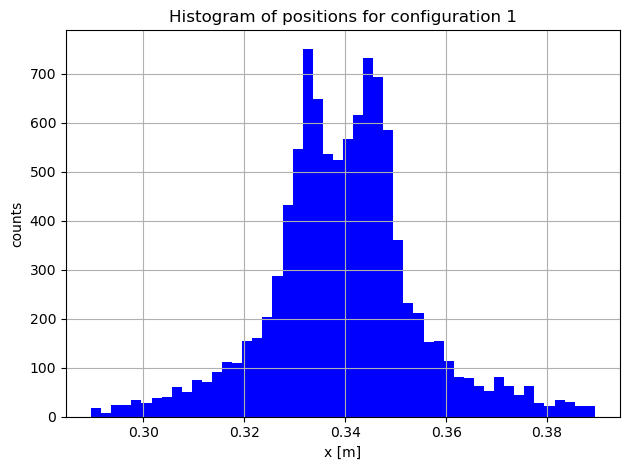


Maxima selcted:
0.343528 - 0.345525 	x: 0.344527 	n: 733
0.357507 - 0.359504 	x: 0.358505 	n: 155

Maxima interval: 0.013978   (n: 3123)

Exterior intervals:
Left:  0.053916   (n: 6208)
Right: 0.029953   (n: 799)

Half maximum: 222.0

FWHM limits:
0.289612 - 0.291609 	x: 0.29061 	n: 18
0.289612 - 0.291609 	x: 0.29061 	n: 18

HWHM for configuration 1: 0.0

Error for configuration 1: 0.019857



Configuration 2:

Average period of oscillation for configuration 2: 0.803683

Equilibrium poisition of configuration 2: -0.000375

Error on equilibrium positions:  0.033844

Dumping: 0.999977

Error on dumping:  0.0021

Friction costant of configuration 2: 17238.127865


C:\Users\Leonardo\AppData\Local\Temp\ipykernel_57116\1505424275.py:353: RuntimeWarning: divide by zero encountered in double_scalars
  gamma = - period / (2 * np.log(s))



The local maxima of the histogram are at:
1 	 0.369479 - 0.37204 	x: 0.37076 	n: 30
2 	 0.402772 - 0.405333 	x: 0.404053 	n: 227
3 	 0.415577 - 0.418138 	x: 0.416858 	n: 133
4 	 0.4207 - 0.423261 	x: 0.42198 	n: 139
5 	 0.430944 - 0.433505 	x: 0.432224 	n: 208
6 	 0.451432 - 0.453993 	x: 0.452712 	n: 64
7 	 0.459115 - 0.461676 	x: 0.460395 	n: 38
8 	 0.469359 - 0.47192 	x: 0.470639 	n: 27
9 	 0.477042 - 0.479603 	x: 0.478322 	n: 14


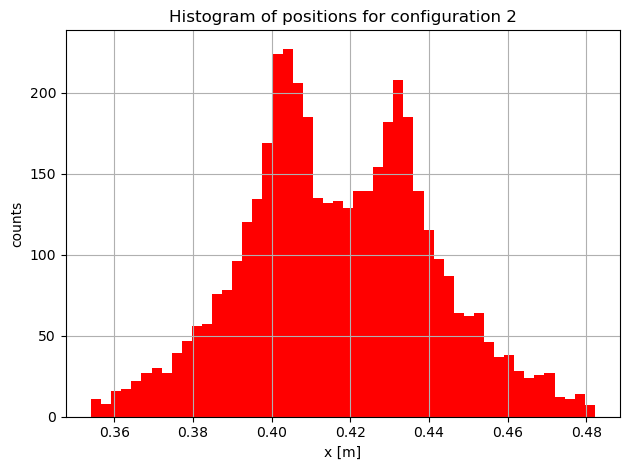


Maxima selcted:
0.415577 - 0.418138 	x: 0.416858 	n: 133
0.451432 - 0.453993 	x: 0.452712 	n: 64

Maxima interval: 0.035854   (n: 1897)

Exterior intervals:
Left:  0.061464   (n: 2139)
Right: 0.028171   (n: 270)

Half maximum: 49.25

FWHM limits:
0.482164 - 0.354113 	x: 0.418138 	n: 7
0.356674 - 0.359235 	x: 0.357955 	n: 8

HWHM for configuration 2: -0.030092

Error for configuration 2: 0.024047



Configuration 3:

Average period of oscillation for configuration 3: 0.877844

Equilibrium poisition of configuration 3: 0.00016

Error on equilibrium positions:  0.026423

Dumping: 1.000009

Error on dumping:  0.001242

Friction costant of configuration 3: -51368.53693


C:\Users\Leonardo\AppData\Local\Temp\ipykernel_57116\1505424275.py:353: RuntimeWarning: divide by zero encountered in double_scalars
  gamma = - period / (2 * np.log(s))



The local maxima of the histogram are at:
1 	 0.33013 - 0.332684 	x: 0.331407 	n: 57
2 	 0.332684 - 0.335238 	x: 0.333961 	n: 57
3 	 0.376102 - 0.378656 	x: 0.377379 	n: 1442
4 	 0.393981 - 0.396535 	x: 0.395258 	n: 1560


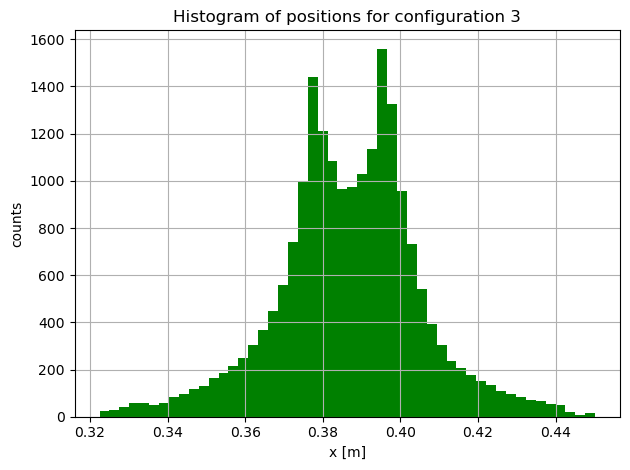


Maxima selcted:
0.376102 - 0.378656 	x: 0.377379 	n: 1442
0.393981 - 0.396535 	x: 0.395258 	n: 1560

Maxima interval: 0.017878   (n: 9404)

Exterior intervals:
Left:  0.053634   (n: 4978)
Right: 0.053634   (n: 5737)

Half maximum: 750.5

FWHM limits:
0.322468 - 0.325022 	x: 0.323745 	n: 26
0.33013 - 0.332684 	x: 0.331407 	n: 57

HWHM for configuration 3: 0.003831

Error for configuration 3: 0.018461


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# function which returns the number of occurnces of each element of an array
def count_occurrences(array):
    
    unique_elements, counts = np.unique(array, return_counts=True)
    
    occurrences = dict(zip(unique_elements, counts))
    
    return occurrences

def max(array):
    
    max_value = array[0]
    
    for i in range(1, len(array)):
        
        if array[i] > max_value:
            
            max_value = array[i]
    
    return max_value

def min(array):
    
    min_value = array[0]
    
    for i in range(1, len(array)):
        
        if array[i] < min_value:
            
            min_value = array[i]
    
    return min_value

# function which returns the local maximums positions and their time value
def local_max(array_x, array_y, fraction):
    
    max_pos = {}
    
    if (fraction == 0):
        delta = 1
    
    else:
        delta = int(len(array_y) / fraction)
    
    i = 1
    j = 1
    while i < (len(array_y)-1):
        
        i_min = i - delta
        i_max = i + delta
        
        if (i_min < 0):    
            i_min = 0
        
        if (i_max > len(array_y)):
            i_max = len(array_y)
        
        if (array_y[i] == max(array_y[i_min:i_max+1])):
        
            max_pos[j] = [array_x[i], array_y[i]]
            j += 1
        
            i = i_max - 1
        
        i += 1
    
    return max_pos

# function which returns the local minimums positions and their time value
def local_min(array_x, array_y, fraction):
    
    min_pos = {}
    
    if (fraction == 0):
        delta = 1
    
    else:
        delta = int(len(array_y) / fraction)
    
    i = 1
    j = 1
    while i < (len(array_y)-1):
        
        i_min = i - delta
        i_max = i + delta
        
        if (i_min < 0):    
            i_min = 0
        
        if (i_max > len(array_y)):
            i_max = len(array_y)
        
        if (array_y[i] == min(array_y[i_min:i_max+1])):
        
            min_pos[j] = [array_x[i], array_y[i]]
            j += 1
        
            i = i_max - 1
        
        i += 1
    
    return min_pos

# funtion which returns the matrix of all the possible periods of oscillations
def periods(array_extremes):
    
    p_osc = {}
    
    for key_1 in array_extremes:
        
        for key_2 in array_extremes:
        
            if (key_2 > key_1):
                
                p_osc[(key_1, key_2)] = ((array_extremes[key_2][0] - array_extremes[key_1][0]) / (key_2 - key_1))
    
    return p_osc

# functions which calculates the mean of the elements of a dictionary
def dic_mean(dic):
    
    n = 0
    sum = 0
    
    for key in dic:
        
        sum += dic[key]
        n += 1
    
    return (sum / n)

# functions which calculates the mean of the elements of an array
def arr_mean(array):
    
    sum = 0
    
    for i in range(len(array)):
        
        sum += array[i]
    
    return (sum / len(array))

# functions which calculates the standard deviation of the elements of an array
def arr_dev_st(array):
    
    sum = 0
    mean = arr_mean(array)
    
    for i in range(len(array)):
        
        sum += (array[i] - mean)**2
    
    return np.sqrt(sum / (len(array) - 1))

# function which returns the highest n values of an array
def find_highest(arr, n):
    
    arr = np.array(arr)
    
    sorted_indices = np.argpartition(arr, -n)[-n:]
    
    highest_values = arr[sorted_indices]
    
    return highest_values

# function which finds index of first element of array less then given value
def find_first_less(array, value):
    
    left = 0
    right = len(array) - 1
    index = -1

    while left <= right:
        
        mid = (left + right) // 2

        if array[mid] < value:
            
            index = mid
            right = mid - 1
        
        else:
            
            left = mid + 1

    return index

# find index of an element of an array
def first_index(array, value):
    
    i = 0
    
    while (i < len(array)):
        
        if (array[i] == value):
            
            return i
        
        i += 1
    
    return -1



# analysis funtion

def analysis(path_equilibrio, path_oscillazioni, int_configurazione, plot_color, extr_color, n_bins, key_max_1, key_max_2):

    # import csv file for equilibrium position as DataFrames
    equilibrio = pd.read_csv(path_equilibrio, sep=';')
    # import csv file for oscillating positions as DataFrames
    oscillazione = pd.read_csv(path_oscillazioni, sep=';')

    # convert DataFrames of equilibrium positions to numpy arrays
    eq_time = equilibrio['time'].to_numpy()
    eq_pos = equilibrio['position'].to_numpy()
    
    print("\n\n\nConfiguration "+str(int_configurazione)+":")

    # plot equilibrium positions
    plt.scatter(eq_time, eq_pos, marker='.', s=1, c=plot_color)
    plt.grid()
    plt.xlabel('t [s]')
    plt.ylabel('x [m]')
    plt.title('Equilibrium positions measured by photogate for configuration '+str(int_configurazione))
    plt.savefig("analisi/smorzamento/plot_equilibrio_"+str(int_configurazione)+".png", dpi=1200)
    plt.close()

    # plot histogran of equilibrium positions
    fig, axs= plt.subplots(1, 1, tight_layout = True)
    axs.hist(eq_pos, bins = 200, color=plot_color)
    plt.grid()
    plt.xlabel('x [m]')
    plt.ylabel('counts')
    plt.title('Histogram of equilibrium positions for configuration '+str(int_configurazione))
    plt.savefig("analisi/smorzamento/plot_equilibrio_"+str(int_configurazione)+"_hist.png", dpi=1200)
    plt.close()

    # print number of equilibrium positions
    with open('analisi/smorzamento/output_equilibrio_'+str(int_configurazione)+'_hist.log','w') as textfile:
        print("Configuration "+str(int_configurazione)+": ", "\n", file=textfile)
        eq_pos_dic = count_occurrences(eq_pos)
        for pos in eq_pos_dic:
            print("x = ", pos, "\t n: ", eq_pos_dic[pos], file=textfile)

    # convert DatFrames of oscillating positions to numpy arrays
    osc_time = oscillazione['time'].to_numpy()
    osc_pos = oscillazione['position'].to_numpy()

    # print maximum positions
    with open('analisi/smorzamento/output_oscillazioni_'+str(int_configurazione)+'_max.log', 'w') as textfile:
        print("Configuration "+str(int_configurazione)+": ", "\n", file=textfile)
        osc_max_dic = local_max(osc_time, osc_pos, 200)

        for key in osc_max_dic:
            print(key, "\t x: ", osc_max_dic[key][1], "\t t: ", osc_max_dic[key][0], file=textfile)
    
    # print minimum positions
    with open('analisi/smorzamento/output_oscillazioni_'+str(int_configurazione)+'_min.log', 'w') as textfile:
        print("Configuration "+str(int_configurazione)+": ", "\n", file=textfile)
        osc_min_dic = local_min(osc_time, osc_pos, 200)

        for key in osc_min_dic:
            print(key, "\t x: ", osc_min_dic[key][1], "\t t: ", osc_min_dic[key][0], file=textfile)
    
    # dictionary of every extreme position
    osc_extr = {}
    
    if (len(osc_max_dic.keys()) > len(osc_min_dic.keys())):
        for key in osc_min_dic:
            osc_extr[2*key-1] = osc_max_dic[key]
            osc_extr[2*key] = osc_min_dic[key]
        osc_extr[2*len(osc_min_dic.keys())+1] = osc_max_dic[len(osc_min_dic.keys())+1]
    elif (len(osc_max_dic.keys()) < len(osc_min_dic.keys())):
        for key in osc_max_dic:
            osc_extr[2*key-1] = osc_min_dic[key]
            osc_extr[2*key] = osc_max_dic[key]
        osc_extr[2*len(osc_max_dic.keys())+1] = osc_min_dic[len(osc_max_dic.keys())+1]
    
    # print minimum positions
    with open('analisi/smorzamento/output_oscillazioni_'+str(int_configurazione)+'.log', 'w') as textfile:
        print("Configuration "+str(int_configurazione)+": ", "\n", file=textfile)
        
        for key in osc_extr:
            print(key, "\t x: ", osc_extr[key][1], "\t t: ", osc_extr[key][0], file=textfile)

    # evaluate period of oscillations
    with open('analisi/smorzamento/output_periodi_'+str(int_configurazione)+'.log', 'w') as textfile:
        print("Configuration "+str(int_configurazione)+": ", "\n", file=textfile)
        
        # using maximum positions
        print("(using maxima)\n", file=textfile)
        p_osc_max = periods(osc_max_dic)

        for i in range(1, len(osc_max_dic)-1):
            for j in range(i+1, len(osc_max_dic)):
                print(i, "-", j, "\t T: ", p_osc_max[(i, j)], file=textfile)

        osc_period_max = dic_mean(p_osc_max)
        print("\n\n\nThe mean period of oscillation is: ", osc_period_max, file=textfile)
        
        # using minimum positions
        print("\n(using minima)\n", file=textfile)
        p_osc_min = periods(osc_min_dic)

        for i in range(1, len(osc_min_dic)-1):
            for j in range(i+1, len(osc_min_dic)):
                print(i, "-", j, "\t T: ", p_osc_min[(i, j)], file=textfile)

        osc_period_min = dic_mean(p_osc_min)
        print("\n\n\nThe mean period of oscillation is: ", osc_period_min, file=textfile)
        
        # using both
        print("\n(half periods)", file=textfile)
        p_osc_extr = periods(osc_extr)

        for i in range(1, len(osc_extr)-1):
            for j in range(i+1, len(osc_extr)):
                print(i, "-", j, "\t T/2: ", p_osc_extr[(i, j)], file=textfile)

        osc_period_extr = dic_mean(p_osc_extr)
        print("\n\n\nThe mean period of oscillation is: ", osc_period_extr, file=textfile)
    
    period = (osc_period_max + osc_period_min + 2*osc_period_extr)/3
    print("\nAverage period of oscillation for configuration "+str(int_configurazione)+":", round(period, 6))
    
    # evaluate equilibrium position
    with open('analisi/smorzamento/output_equilibrio_'+str(int_configurazione)+'.log', 'w') as textfile:
        print("Configuration "+str(int_configurazione)+": ", "\n", file=textfile)
        
        x_eq = []
        
        for i in range(1, len(osc_extr)-1):
            x = (osc_extr[i][1] * osc_extr[i+2][1] - (osc_extr[i+1][1])**2) / (2 * osc_extr[i+1][1] + osc_extr[i][1] + osc_extr[i+2][1])
            x_eq.append(x)
            print(i, "-", (i+1), "-", (i+2), "\t x: ", x, file=textfile)
        
    print("\nEquilibrium poisition of configuration "+str(int_configurazione)+":", round(arr_mean(x_eq),6))
    print("Error on equilibrium positions: ", round(arr_dev_st(x_eq),6))
    
    # evaluate dumping
    with open('analisi/smorzamento/output_smorzamento_'+str(int_configurazione)+'.log', 'w') as textfile:
        print("Configuration "+str(int_configurazione)+": ", "\n", file=textfile)
        
        s_mean = []
        
        for i in range(1, len(osc_extr)-1):
            s = (osc_extr[i+2][1] + osc_extr[i+1][1]) / (osc_extr[i+1][1] + osc_extr[i][1])
            gamma = - period / (2 * np.log(s))
            s_mean.append(s)
            print(i, "-", (i+1), "-", (i+2), "\t s: ", s, "\t gamma:", gamma, file=textfile)
        
    print("\nDumping:", round(arr_mean(s_mean),6))
    print("Error on dumping: ", round(arr_dev_st(s_mean),6))
    gamma = - period / (2 * np.log(arr_mean(s_mean)))
    print("Friction costant of configuration "+str(int_configurazione)+":", round(gamma,6))

    # plot oscillating positions
    plt.scatter(osc_time, osc_pos, marker='.', s=1, c=plot_color)
    for key in osc_extr:
        plt.scatter(osc_extr[key][0], osc_extr[key][1], marker='.', s=3, c=extr_color)
    plt.grid()
    plt.xlabel('t [s]')
    plt.ylabel('x [m]')
    plt.title('Positions measured by photogate for configuration '+str(int_configurazione))
    plt.savefig("analisi/smorzamento/plot_oscillazione_"+str(int_configurazione)+".png", dpi=1200)
    plt.close()
    
    # analysis of oscillating positions
    pos_hist, pos_bins = np.histogram(osc_pos, n_bins)
    
    def position(i):
        return ((pos_bins[i]+pos_bins[i+1])/2)
    
    max_hist = local_max(np.array(range(0, len(pos_hist))), pos_hist, 0)
    
    with open('analisi/smorzamento/output_oscillazioni_'+str(int_configurazione)+'_hist.log', 'w') as textfile:
        print("Configuration "+str(int_configurazione)+": ", "\n", file=textfile)
        
        for i in range(len(pos_hist)):           
            print(round(pos_bins[i],6), "-", round(pos_bins[i+1],6), "\tx:", round(position(i),6), "\tn:", pos_hist[i], file=textfile)
        
        print("\n\nThe local maxima of the histogram are at:", file=textfile)
        print("\nThe local maxima of the histogram are at:")
        
        for key in max_hist:
            print(round(pos_bins[max_hist[key][0]],6), "-", round(pos_bins[max_hist[key][0]+1],6), "\tx:", round(position(max_hist[key][0]),6), "\tn:", pos_hist[max_hist[key][0]], file=textfile)
            print(key, "\t",  round(pos_bins[max_hist[key][0]],6), "-", round(pos_bins[max_hist[key][0]+1],6), "\tx:", round(position(max_hist[key][0]),6), "\tn:", pos_hist[max_hist[key][0]])
    
    # plot histogran of oscillating positions
    fig, axs= plt.subplots(1, 1, tight_layout = True)
    N, bins, patches = axs.hist(osc_pos, bins = n_bins, color=plot_color)
    plt.grid()
    plt.xlabel('x [m]')
    plt.ylabel('counts')
    plt.title('Histogram of positions for configuration '+str(int_configurazione))
    plt.savefig("analisi/smorzamento/plot_oscillazione_"+str(int_configurazione)+"_hist.png", dpi=1200)
    plt.show()
    
    # evaluation of the error of oscillating positions
    i_max_1 = max_hist[key_max_1][0]
    i_max_2 = max_hist[key_max_2][0]
    max_1 = position(i_max_1)
    max_2 = position(i_max_2)
    n_max_1 = pos_hist[i_max_1]
    n_max_2 = pos_hist[i_max_2]
    max_mean = (max_1 * n_max_1 + max_2 * n_max_2) / (n_max_1 + n_max_2)
    n_max_mean = (n_max_1 + n_max_2) / 2
    
    i_half_1 = find_first_less(pos_hist[0:i_max_1+1], n_max_mean/2)
    i_half_2 = find_first_less(pos_hist[i_max_2:-1], n_max_mean/2)
    
    hwhm = (position(i_half_2) - position(i_half_1)) / 2
    
    error = ((max_1 - position(0))*(sum(pos_hist[0:i_max_1])) + (position(len(pos_hist)-1) - max_2)*(sum(pos_hist[i_max_2+1:len(pos_hist)])) + (max_2 - max_1)*(sum(pos_hist[i_max_1:i_max_2+1]))) / (sum(pos_hist))
    
    print("\nMaxima selcted:")
    print(round(pos_bins[i_max_1],6), "-", round(pos_bins[i_max_1+1],6), "\tx:", round(max_1,6), "\tn:", n_max_1)
    print(round(pos_bins[i_max_2],6), "-", round(pos_bins[i_max_2+1],6), "\tx:", round(max_2,6), "\tn:", n_max_2)
    
    print("\nMaxima interval:", round(max_2 - max_1,6), "  (n: "+str(sum(pos_hist[i_max_1:i_max_2+1]))+")")
    print("\nExterior intervals:")
    print("Left: ", round(max_1 - position(0),6), "  (n: "+str(sum(pos_hist[0:i_max_1]))+")")
    print("Right:", round(position(len(pos_hist)-1) - max_2,6), "  (n: "+str(sum(pos_hist[i_max_2+1:len(pos_hist)]))+")")
    
    print("\nHalf maximum:", round(n_max_mean/2,6))
    
    print("\nFWHM limits:")
    print(round(pos_bins[i_half_1],6), "-", round(pos_bins[i_half_1+1],6), "\tx:", round(position(i_half_1),6), "\tn:", pos_hist[i_half_1])
    print(round(pos_bins[i_half_2],6), "-", round(pos_bins[i_half_2+1],6), "\tx:", round(position(i_half_2),6), "\tn:", pos_hist[i_half_2])
    
    print("\nHWHM for configuration "+str(int_configurazione)+":", round(hwhm,6))
    
    print("\nError for configuration "+str(int_configurazione)+":", round(error/2,6))


analysis('dati/smorzamento/equilibrio_1.csv', 'dati/smorzamento/oscillazione_1.csv', 1, 'blue', 'red', 50, 6, 7)
analysis('dati/smorzamento/equilibrio_2.csv', 'dati/smorzamento/oscillazione_2.csv', 2, 'red', 'blue', 50, 3, 6)
analysis('dati/smorzamento/equilibrio_3.csv', 'dati/smorzamento/oscillazione_3.csv', 3, 'green', 'red', 50, 3, 4)